# Proyecto 6: Sistemas de recomendación

## Dataset

El dataset que vamos a usar en este proyecto es el del proyecto [MovieLens](http://grouplens.org/datasets/movielens/). Estos son relevados por el grupo de investigación GroupLens de la Universidad de Minnesota. Vamos a usar la versión 100K.

Está basado en un sistema de rating de 5 estrellas y texto libre para tags a partir del servicio de recomendaciones MovieLens. Contiene 100.000 ratings para 1.682 películas. Los datos fueron creados por 943 usuarios.

En el [Readme](http://files.grouplens.org/datasets/movielens/ml-100k-README.txt) del dataset se puede encontrar información adicional. A continuación vamos a describir cada uno de ellos.

### Ratings (u.data)

Cada línea representa el rating para una película para un usuario. Los ratings están basados en un sistema de 5 estrellas, con una salto de 0.5 estrellas. Los timestamps están expresados en segundos desde la medianoche de 01/1970 (UTC). El formato es:

`user id | item id | rating | timestamp`

### Usuarios (u.users)

Cada línea del archivo representa un usuario. Se incluye información demográfica. El formato es:

`user id | age | gender | occupation | zip code`

### Películas (u.item)

Cada línea corresponde a una película. Puede haber inconsistencias en los nombres. El formato es:

`movie id | movie title | release date | video release date | IMDb URL | generos`



Las columnas con los generos son binarias indicando la presencia o ausencia de cada uno en la película. Los géneros pueden ser:

* Action
* Adventure
* Animation
* Children's
* Comedy
* Crime
* Documentary
* Drama
* Fantasy
* Film-Noir
* Horror
* Musical
* Mystery
* Romance
* Sci-Fi
* Thriller
* War
* Western
* unknown

## Experimentación

Durante todo este proyecto vamos a utilizar la librería `surprise` para llevar a cabo las experimentaciones.

Como se mencionó en clase, las implementaciones en esta librería tiene algunas mejoras respecto de las estrategias convencionales como SVD. Esto se traduce en una mayor cantidad de parámetros para optimizar.

Vamos a levantar los datos. En primer lugar, definamos el formato para poder leer los datos.

**1) Utilizar** el `Reader` con el parámetro `line_format` igual a `'user item rating timestamp'` y `sep` como `'\t'`. Guardarlo en una variable `reader`.

In [29]:
from surprise import Dataset
from surprise import Reader
reader = Reader(line_format='user item rating timestamp', sep='\t')

Utilizando este `reader` cargar los datos:

In [3]:
data = Dataset.load_from_file('./dataset/ml-100k/u.data', reader=reader)

__2) Ejecutar una corrida inicial usando cross validation y el algoritmo SVD (5 folds). Imprimir los RMSE de testing.__

In [5]:
from surprise import SVD
from surprise import KNNBasic
from surprise.model_selection import cross_validate

svd = SVD()
cv = cross_validate(svd, data, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9385  0.9271  0.9390  0.9406  0.9385  0.9367  0.0049  
Fit time          4.04    3.83    4.00    3.83    3.81    3.90    0.10    
Test time         0.20    0.14    0.16    0.16    0.15    0.16    0.02    


__3) Evaluar el RMSE (promedio de cross validation) de testing de acuerdo a la cantidad de factores en SVD.__

In [12]:
import numpy as np
rmse_test_means = []

factors = [5,100,200]
for factor in factors:
    algo = SVD(n_factors=factor)
    cv = cross_validate(algo, data, measures=['RMSE'],  cv=3, verbose=False)
    rmse_test_means.append(np.mean(cv['test_rmse']))

In [13]:
rmse_test_means

[0.9424586573850481, 0.9448429387900772, 0.950894168499984]

veo que el rmse promedio va aumentando a media que aumenta la cantidad de factores

__4) Graficar los promedios RMSE del conjunto de testing de acuerdo a la cantidad de factores en SVD.__

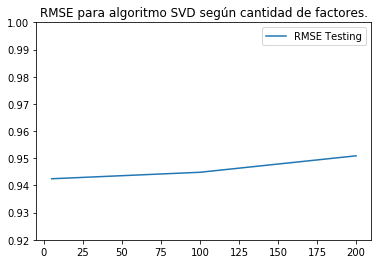

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline 
plt.plot(factors, rmse_test_means, label='RMSE Testing')
plt.ylim((0.92, 1.0))
plt.legend(loc="best")
plt.title("RMSE para algoritmo SVD según cantidad de factores.")
plt.show()

__5) Usando GridSearch, encontrar el mejor estimador usando SVD con 500 factores. Imprimir el mejor rmse. Utilizar `refit` para obtener obtener el mejor estimador ya ajustado como resultado.__

Utilizar el espacio de parámetros:
* n_epochs: [5, 10]
* lr_all: [0.002, 0.005]
* reg_all: [0.4, 0.6]


In [10]:
from surprise.model_selection import GridSearchCV

In [63]:
parameters = {
    'n_epochs': [5, 10],
    'lr_all': [0.002, 0.005],
    'reg_all': [0.4, 0.6],
    'n_factors':[500]
}

gs =  GridSearchCV(SVD, param_grid=parameters, cv=5, measures=['rmse'], refit=True)

In [64]:
gs.fit(data)

In [65]:
print(gs.best_params['rmse'])

{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4, 'n_factors': 500}


In [66]:
print(gs.best_score['rmse'])

0.9621051919200794


__6) Obtener una predicción para el usuario 321 para la película Titanic.__

In [68]:
gs.predict('321','313')

Prediction(uid='321', iid='313', r_ui=None, est=3.979327350966055, details={'was_impossible': False})

__7) Desarrollar una función que dado un usuario, obtenga la mejor predicción disponible (de acuerdo a nuestros datos de películas).__

In [69]:
def get_prediction(data, usuario, item):
    parameters = {
        'n_epochs': [5, 10],
        'lr_all': [0.002, 0.005],
        'reg_all': [0.4, 0.6],
        'n_factors':[500]
        }

    gs =  GridSearchCV(SVD, param_grid=parameters, cv=5, measures=['rmse'], refit=True)
    gs.fit(data)
    pred = gs.predict(usuario, item)
    return pred